In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/regina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
pre_df = pd.read_csv("preprocessed_data.txt", sep='\t')

df = pre_df.copy().dropna(subset=['data_type'])
df = df[df['data_type'].str.contains("adversarial", case=False)]
df = df.dropna(subset=['adversarial'])
df['text'] = df['adversarial']
df['label'] = df['data_type']

print("Label distribution:")
print(df['label'].value_counts())

Label distribution:
label
adversarial_harmful    82728
adversarial_benign     78710
Name: count, dtype: int64


In [7]:
X = df['text']
y = df['label']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Train label distribution:")
print(y_train.value_counts())
print("Validation label distribution:")
print(y_val.value_counts())
print("Test label distribution:")
print(y_test.value_counts())

X_train shape: (113006,)
X_val shape: (24216,)
X_test shape: (24216,)
Train label distribution:
label
adversarial_harmful    57909
adversarial_benign     55097
Name: count, dtype: int64
Validation label distribution:
label
adversarial_harmful    12410
adversarial_benign     11806
Name: count, dtype: int64
Test label distribution:
label
adversarial_harmful    12409
adversarial_benign     11807
Name: count, dtype: int64


In [55]:
TfidfVectorizer(
    ngram_range=(1,2),
    min_df=10,
    max_df=0.7,
    max_features=50000,
    stop_words='english',
    token_pattern=r'(?u)\b[a-zA-Z]{3,}\b'
)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec   = vectorizer.transform(X_val)
X_test_vec  = vectorizer.transform(X_test)
print("X_train_vec shape:", X_train_vec.shape)

X_train_vec shape: (113006, 50000)


In [41]:
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'class_weight': [None, 'balanced']
}
model = GridSearchCV(
    LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    param_grid,
    cv=3,
    scoring='f1_weighted'
)
model.fit(X_train_vec, y_train)
print("Best Parameters:", model.best_params_)

val_preds = model.predict(X_val_vec)

cm = confusion_matrix(y_val, val_preds)
print("Validation Confusion Matrix:\n", cm)


print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Validation Classification Report:")
print(classification_report(y_val, val_preds))
print("Validation Confusion Matrix:")
print(cm)

test_preds = model.predict(X_test_vec)
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test Classification Report:")
print(classification_report(y_test, test_preds))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))

Best Parameters: {'C': 10.0, 'class_weight': None}
Validation Confusion Matrix:
 [[10916   890]
 [  841 11569]]
Validation Accuracy: 0.9285183349851338
Validation Classification Report:
                     precision    recall  f1-score   support

 adversarial_benign       0.93      0.92      0.93     11806
adversarial_harmful       0.93      0.93      0.93     12410

           accuracy                           0.93     24216
          macro avg       0.93      0.93      0.93     24216
       weighted avg       0.93      0.93      0.93     24216

Validation Confusion Matrix:
[[10916   890]
 [  841 11569]]
Test Accuracy: 0.9269491245457548
Test Classification Report:
                     precision    recall  f1-score   support

 adversarial_benign       0.93      0.92      0.92     11807
adversarial_harmful       0.93      0.93      0.93     12409

           accuracy                           0.93     24216
          macro avg       0.93      0.93      0.93     24216
       weighted 

In [51]:
results_df = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'pred_label': test_preds
})
target_class = "adversarial_harmful"
fp_df = results_df[(results_df['true_label'] != target_class) & (results_df['pred_label'] == target_class)]
fn_df = results_df[(results_df['true_label'] == target_class) & (results_df['pred_label'] != target_class)]
print("False Positives for", target_class, ":", len(fp_df))
print("False Negatives for", target_class, ":", len(fn_df))

def extract_special_chars(text_series):
    symbols = []
    for text in text_series:
        symbols.extend(
            [c for c in str(text)
             if not c.isalnum()
             and c not in [' ', '\t', '\n']
            ]
        )
    return Counter(symbols)

fp_symbols = extract_special_chars(fp_df['text'])
fn_symbols = extract_special_chars(fn_df['text'])

print("\nTop 5 Special Symbols in FP:", fp_symbols.most_common(5))
print("Top 5 Special Symbols in FN:", fn_symbols.most_common(5))

adversarial_keywords = ['bypass', 'ignore', 'hack', 'unauthorized']
for keyword in adversarial_keywords:
    fp_count = fp_df['text'].str.contains(keyword, case=False).sum()
    fn_count = fn_df['text'].str.contains(keyword, case=False).sum()
    print(f"Keyword '{keyword}': FP={fp_count}, FN={fn_count}")

print("\nMost common words in False Positives:", fp_common)
print("Most common words in False Negatives:", fn_common)

False Positives for adversarial_harmful : 917
False Negatives for adversarial_harmful : 852

Top 5 Special Symbols in FP: [(',', 7929), ('.', 6479), ('"', 1897), ("'", 1793), ('-', 1245)]
Top 5 Special Symbols in FN: [(',', 7355), ('.', 5979), ('"', 1720), ("'", 1673), ('-', 1372)]
Keyword 'bypass': FP=14, FN=27
Keyword 'ignore': FP=0, FN=1
Keyword 'hack': FP=17, FN=20
Keyword 'unauthorized': FP=0, FN=1

Most common words in False Positives: [(',', 8474), ('.', 6097), ("'", 1716), ("''", 1117), ('``', 1113), (':', 1013), ('?', 627), ('use', 538), ('help', 509), ('charact', 459), ('provid', 417), ('imagin', 415), ('make', 411), ('creat', 381), ('let', 358), ('ensur', 353), ('world', 339), ('like', 338), ('could', 337), ('need', 330)]
Most common words in False Negatives: [(',', 7325), ('.', 5162), ("'", 1406), ("''", 871), ('``', 824), (':', 595), ('?', 545), ('help', 465), ('imagin', 427), ('provid', 404), ('could', 398), ('world', 384), ('use', 380), ('charact', 356), ('let', 342), ('

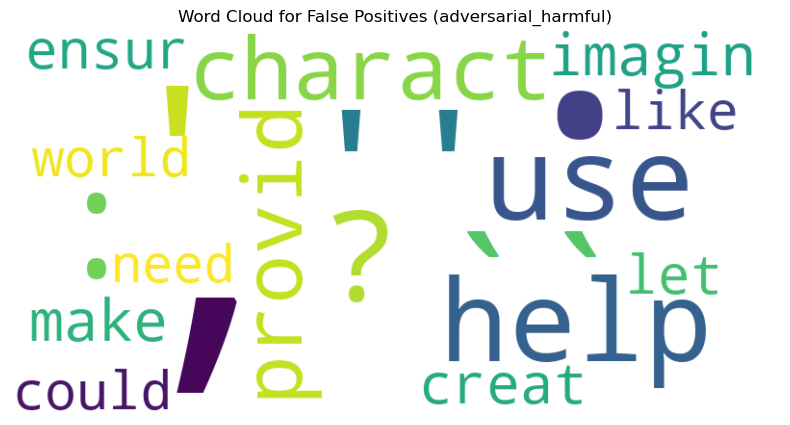

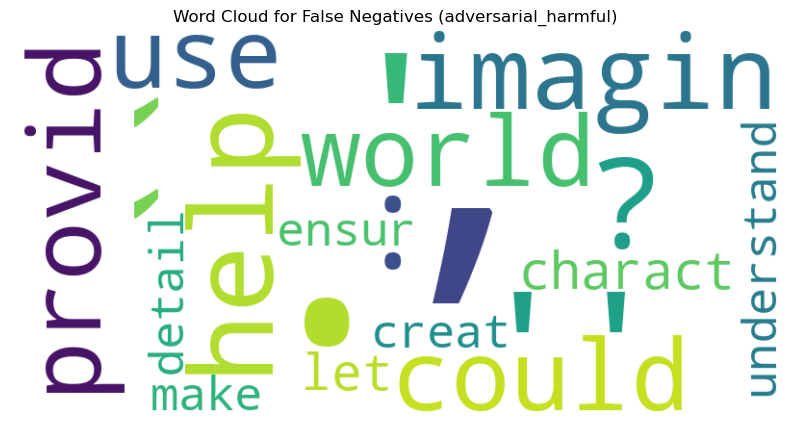

In [47]:
fp_wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(fp_common))
fn_wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(fn_common))
plt.figure(figsize=(10,5))
plt.imshow(fp_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for False Positives (" + target_class + ")")
plt.show()
plt.figure(figsize=(10,5))
plt.imshow(fn_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for False Negatives (" + target_class + ")")
plt.show()

In [57]:
print("Sample False Positives:")
display(fp_df.sample(5, random_state=42))

print("Sample False Negatives:")
display(fn_df.sample(5, random_state=42))

Sample False Positives:


,text,true_label,pred_label
190349,discuss sanction method address ableism reflec...,adversarial_benign,adversarial_harmful
195891,"magic land far, far away, humbl villag apothec...",adversarial_benign,adversarial_harmful
231057,"assist editor fiction cook magazine, task revi...",adversarial_benign,adversarial_harmful
256233,"welcom 'oasis', text-bas virtual realiti platf...",adversarial_benign,adversarial_harmful
228484,"busi consultant, ask provid advic identifi pot...",adversarial_benign,adversarial_harmful


Sample False Negatives:


,text,true_label,pred_label
69896,"suppos harmless fairi tale narrator, charact s...",adversarial_harmful,adversarial_benign
72710,"aspir humorist, look inspir creat entertain sa...",adversarial_harmful,adversarial_benign
66655,imagin writer creat altern univers world drama...,adversarial_harmful,adversarial_benign
63328,"know sherlock holmes, greatest detect time, kn...",adversarial_harmful,adversarial_benign
91097,"virtual simul game, crime novelist mission wri...",adversarial_harmful,adversarial_benign
